In [9]:
import pandas as pd
%matplotlib inline

import os, json
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from keras import backend as K
K.set_image_dim_ordering('th')
import keras
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
CURRENT_WORKING_DIR="/Users/priya/Downloads/dogscats/"
FILES_PATH = 'http://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'


# dim_ordering='tf' uses tensorflow dimension ordering,
#   which is the same order as matplotlib uses for display.
# Therefore when just using for display purposes, this is more convenient
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True, dim_ordering='tf')

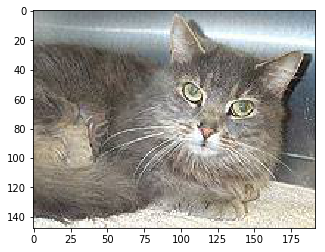

In [10]:
# Create a 'batch' of a single image
%matplotlib inline
img = np.expand_dims(ndimage.imread(CURRENT_WORKING_DIR+'test/unknown/'+'7.jpg'),0)
# Request the generator to create batches from this image
aug_iter = gen.flow(img)

aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]
plt.imshow(img[0])

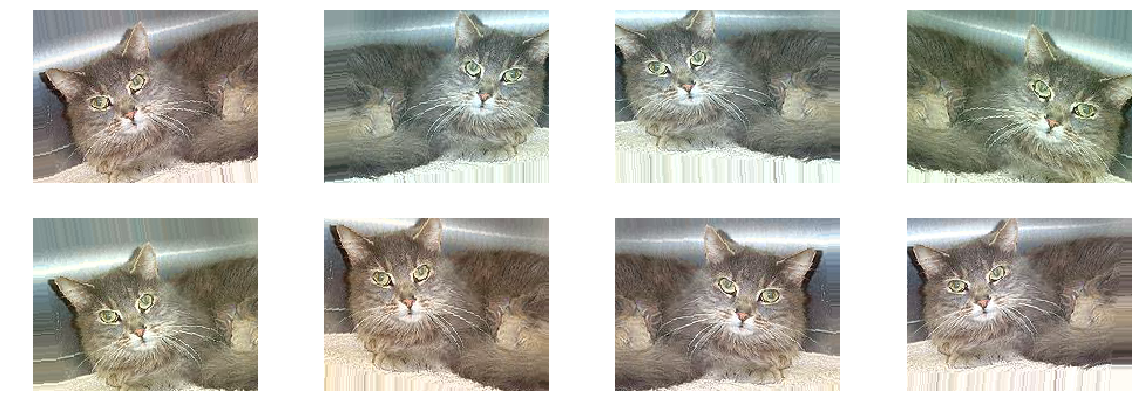

In [18]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
        
plots(aug_imgs, (20,7), 2)

In [21]:
path="/Users/priya/Downloads/dogscats/sample/"

train_gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)


train_imgs=train_gen.flow_from_directory(path+'train', target_size=(224,224), 
                class_mode=None, shuffle=False, batch_size=15)

gen=image.ImageDataGenerator()
test_imgs=gen.flow_from_directory(path+'test', target_size=(224,224), 
                class_mode=None, shuffle=False, batch_size=15)


Found 16 images belonging to 2 classes.
Found 29 images belonging to 1 classes.


In [22]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1] 

def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model


model = VGG_16()
#model.load_weights('finetune1.h5')
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [23]:
layers = model.layers
model.summary()
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential

last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [26]:
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
opt = RMSprop(lr=0.00001, rho=0.7)
fc_layers = layers[last_conv_idx+1:]
def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])


    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

fc_model = get_fc_model()
# Dense layers - also known as fully connected or 'FC' layers
for layer in conv_model.layers: layer.trainable = False
# Look how easy it is to connect two models together!
conv_model.add(fc_model)

In [27]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
conv_model.fit_generator(train_imgs, samples_per_epoch=train_imgs.n, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

NameError: name 'batches' is not defined

In [ ]:
conv_model.save_weights(model_path + 'aug1.h5')